In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam
import flax
import jax_dataclasses as jdc
import tqdm

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
DATAFILE = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [3]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [4]:
LASER_DATA_LIST = []
with open(DATAFILE, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        LASER_DATA_LIST.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [5]:
def show_points(laser_data_list, indeces):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")

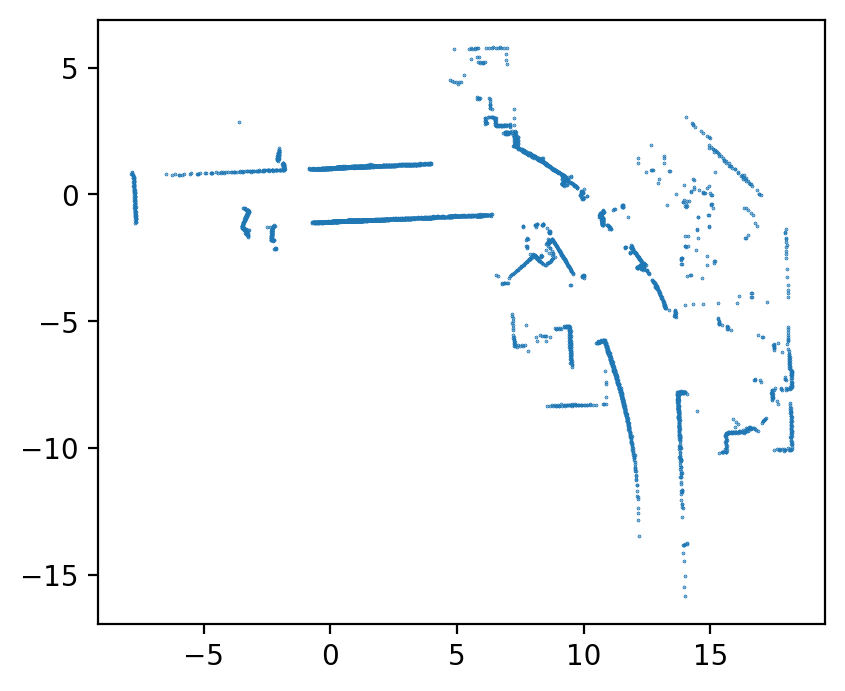

In [6]:
laser_data_list = LASER_DATA_LIST
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

# Rendering

In [7]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [8]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [9]:
MODEL = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
VARIABLES = MODEL.init(jax.random.PRNGKey(1), batch)
output = MODEL.apply(VARIABLES, batch)

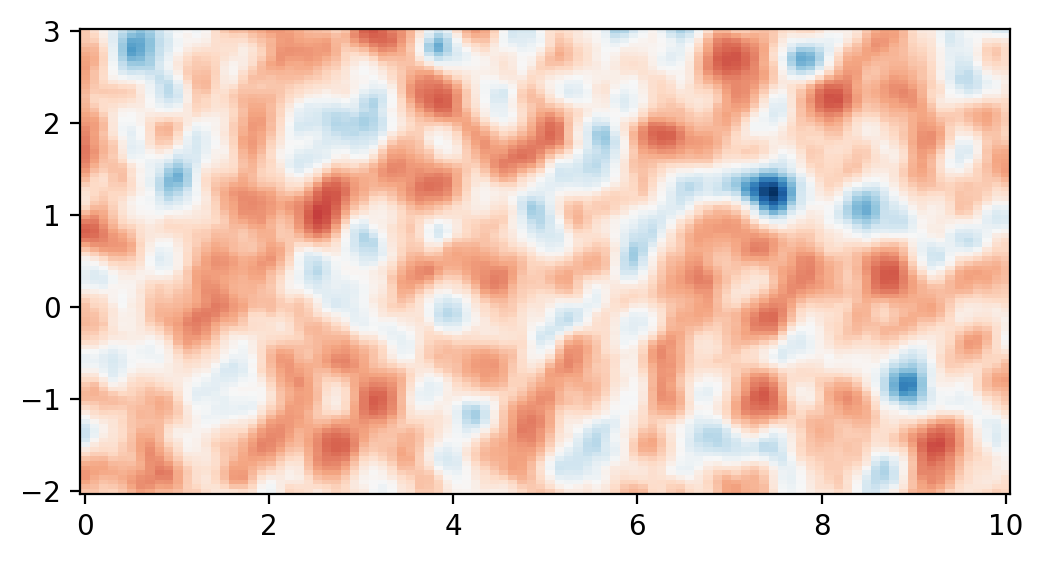

In [10]:
plt.figure(dpi=200)
k = 1
k = 1
bounds = (0 * k, 10 * k, -2 * k, 3 * k)
grid_shape=(200, 200)
plot_model_heatmap(MODEL, VARIABLES, bounds, grid_shape)

# Space hashing

In [11]:
@jax.jit
def hashfunction(x, T):
    pi1 = 1
    pi2 = 19349663
    pi3 = 83492791
    result = jnp.bitwise_xor(x[:, 0] * pi1, x[:, 1] * pi2)
    return result % T

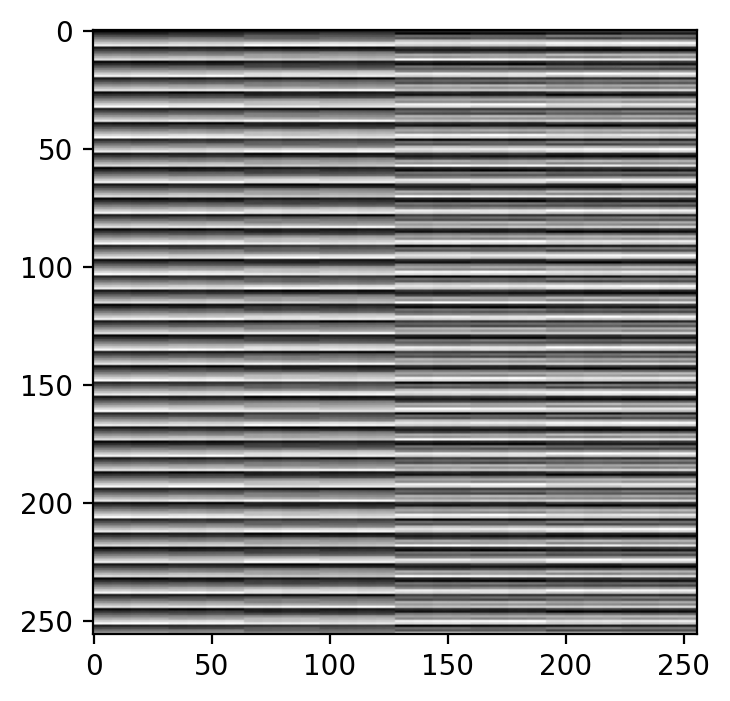

In [12]:
x, y = jnp.meshgrid(jnp.arange(256), jnp.arange(256))
points = jnp.stack([x, y], axis=2)
values = hashfunction(points.reshape(-1, 2), 1024).reshape(256, 256)
plt.figure(dpi=200)
plt.imshow(values, cmap="gray")

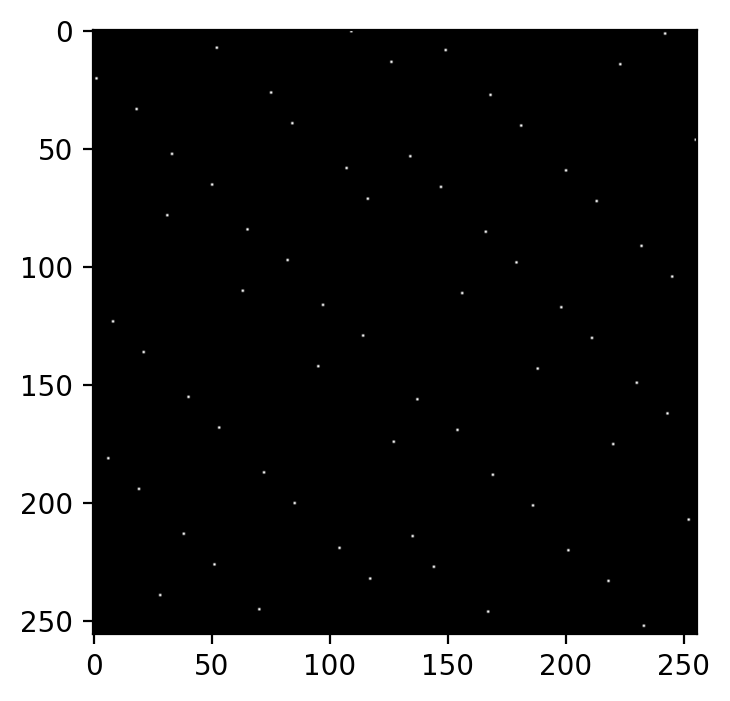

In [13]:
random_reindex = np.random.choice(np.arange(1024), 1024, replace=False)
random_reindex = jnp.array(random_reindex)
plt.figure(dpi=200)
plt.imshow(random_reindex[values] == 30, cmap="gray")

In [134]:
class MLPModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, use_bias=True)(x)
        x = nn.relu(x)
#         x1 = x
#         x1 = nn.Dense(256)(x1)
#         x1 = nn.relu(x1)
#         x = jnp.concatenate([x, x1], axis=-1)
# #         x = x1
#         x = nn.Dense(256)(x)
#         x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]

In [135]:
def step_function(x):
    return x * x * (3 - 2 * x)

@jax.jit
def bilinear_interpolation(deltas, values0, values1, values2, values3):
    f1 = values0 * step_function(1 - deltas[:, 0])[:, None] + values1 * step_function(deltas)[:, 0][:, None]
    f2 = values2 * step_function(1 - deltas[:, 0])[:, None] + values3 * step_function(deltas)[:, 0][:, None]
    return f1 * step_function(1 - deltas[:, 1])[:, None] + f2 * step_function(deltas)[:, 1][:, None]

@jax.jit
def calculate_layer_embeddings(hashtable, points, resolution, origin, T, rotation):
    points = ((points - origin) / resolution)
    x = jnp.cos(rotation) * points[:, 0] - jnp.sin(rotation) * points[:, 1]
    y = jnp.sin(rotation) * points[:, 0] + jnp.cos(rotation) * points[:, 1]
    points = jnp.stack([x, y], axis=1)
    cells = jnp.array(points // 1, jnp.int32)
    deltas = points % 1
    values0 = hashtable[hashfunction(cells, T)]
    values1 = hashtable[hashfunction(cells + jnp.array([1, 0]), T)]
    values2 = hashtable[hashfunction(cells + jnp.array([0, 1]), T)]
    values3 = hashtable[hashfunction(cells + jnp.array([1, 1]), T)]
    return bilinear_interpolation(deltas, values0, values1, values2, values3)

# Train hashtabel

In [572]:
@jdc.pytree_dataclass
class MapModel(object):
    hashtable: jnp.array
    variables: flax.core.frozen_dict.FrozenDict
    resolutions: jnp.array
    origins: jnp.array
    rotations: jnp.array
        
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    F: int
    L: int
    T: int
    max_log_resolution: float
    min_log_resolution: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [586]:
@functools.partial(jax.jit, static_argnums=2)
def calculate_densities(points: jnp.array, map_model: MapModel, model: MLPModel):
    embeddings = []
    for i in range(map_model.hashtable.shape[0]):
        embedding = calculate_layer_embeddings(map_model.hashtable[i], 
                                               points, 
                                               map_model.resolutions[i], 
                                               map_model.origins[i], 
                                               map_model.hashtable.shape[1], 
                                               map_model.rotations[i])
        embeddings.append(embedding)
    embedding = jnp.stack(embeddings, axis=0)
    embedding = jnp.sum(embedding, axis=0)
    return jax.nn.softplus(model.apply(map_model.variables, embedding))

In [587]:
# calculate_densities(grid, map_model, model);

In [588]:
# %timeit calculate_densities(grid, map_model, model).block_until_ready()

In [589]:
# grid_shape=(20, 10)
# grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
#                               jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
# grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
# # jax.make_jaxpr(calculate_densities, static_argnums=2)(grid, map_model, model)
# print(jax.make_jaxpr(calculate_densities, static_argnums=2)(grid, map_model, model))

In [590]:
def plot_model_heatmap(map_model, bounds):

    grid_shape=(200, 200)
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
                              jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = calculate_densities(grid, map_model, model)
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(*grid_shape)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

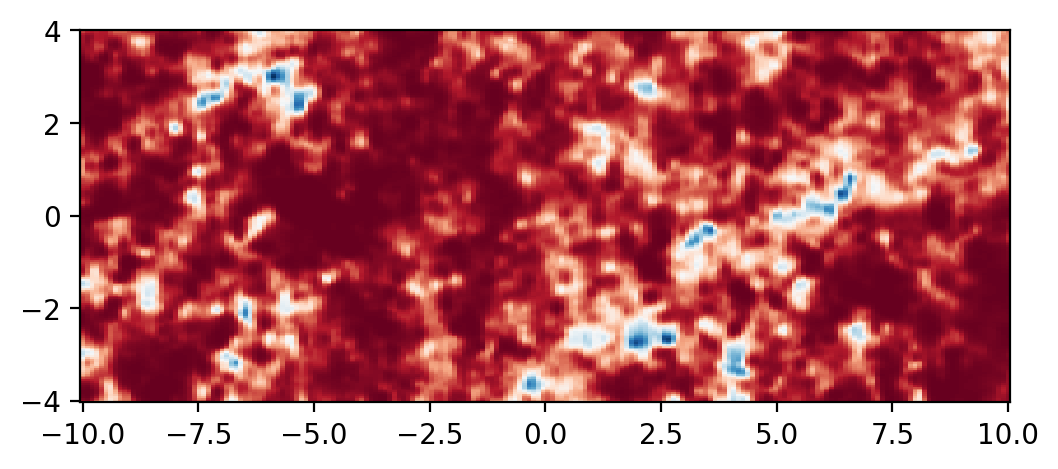

In [591]:
plt.figure(dpi=200)
F=8
L=16
T=2048
hashtable = jax.random.normal(jax.random.PRNGKey(1), (L, T, F))
resolutions = 2 ** jnp.linspace(-2, 3, L)
origins = jnp.zeros(2) + jax.random.normal(jax.random.PRNGKey(2), (L, 2))
rotations = jax.random.uniform(jax.random.PRNGKey(10), (L,)) * 2 * np.pi
k = 1
# bounds = (0 * k, 10 * k, -2 * k, 3 * k)
bounds = (-10, 10, -4, 4)
grid_shape=(400, 400)

model = MLPModel()
batch = jnp.ones([10, F])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)
map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=resolutions,
                     origins=origins, rotations=rotations)
plot_model_heatmap(map_model, bounds)

In [858]:
@jdc.pytree_dataclass
class ScanData(object):
    depths: jnp.array
    angles: jnp.array

        
@jdc.pytree_dataclass
class LearningData(object):
    uniform: jnp.array
        
        
@jdc.pytree_dataclass
class Position(object):
    x: jnp.array
    y: jnp.array
    angle: jnp.array


        
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(learning_data, parameters):
    return sample_depth_bins_exp(learning_data, parameters)
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * learning_data.uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins_exp(learning_data, parameters):
    weights = jnp.exp(jnp.linspace(0, 1, parameters.bins_count) * 0.017)
    deltas = weights / jnp.sum(weights) * (parameters.maximal_depth - parameters.minimal_depth)
    depths = jnp.cumsum(deltas) + parameters.minimal_depth
    sampled_depths = depths[None] + learning_data.uniform * deltas[None]
    return jnp.concatenate([jnp.full([sampled_depths.shape[0], 1], parameters.minimal_depth), 
                            sampled_depths, 
                            jnp.full([sampled_depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, position):
    x = position[0, None]
    y = position[1, None]
    angle = position[2, None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, scan_data: ScanData):
    x = depths * jnp.cos(scan_data.angles[..., None])
    y = depths * jnp.sin(scan_data.angles[..., None])
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=[4, 5])
def loss_function(map_model: MapModel, position: jnp.array, scan_data: ScanData, 
                  learning_data:LearningData, config: ModelConfig, model: MLPModel):
    depth_bins = sample_depth_bins(learning_data, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = config.density_scale * calculate_densities(points, map_model, model).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((scan_data.depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4) +
                   config.variance_weight * predicted_variance)
#     return jnp.mean((scan_data.depths - predicted_depths) ** 2  + config.variance_weight * predicted_variance)

@functools.partial(jax.jit, static_argnums=[4, 5])
def predict_dephs(map_model: MapModel, position: jnp.array, scan_data: ScanData, 
                  learning_data:LearningData, config: ModelConfig, model: MLPModel):
    depth_bins = sample_depth_bins(learning_data, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = config.density_scale * calculate_densities(points, map_model, model).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    return jnp.sum(weights * extended_depths, axis=-1)


In [859]:
def init_map_model(model, config):
    hashtable = jax.random.normal(jax.random.PRNGKey(1), (config.L, config.T, config.F))
    resolutions = 2 ** jnp.linspace(config.min_log_resolution, config.max_log_resolution, config.L)
    origins = jnp.zeros(2) + jax.random.normal(jax.random.PRNGKey(2), (config.L, 2))
    rotations = jax.random.uniform(jax.random.PRNGKey(10), (L,)) * 2 * np.pi
#     batch = jnp.ones([10, config.F * config.L])
    batch = jnp.ones([10, config.F])
    variables = model.init(jax.random.PRNGKey(1), batch)
    output = model.apply(variables, batch)
    return MapModel(hashtable=hashtable, variables=variables, resolutions=resolutions,
                         origins=origins, rotations=rotations)

In [860]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.5,
    variance_weight=0.5,
    F=2,
    L=16,
    T=1024,
    min_log_resolution=-1.,
    max_log_resolution=3.
)
n = 256
position = jnp.ones(3)
scan_data = ScanData(angles=jnp.ones(n), depths=jnp.ones(n))
learning_data = LearningData(uniform=jnp.ones([n, config.bins_count]))
map_model =  init_map_model(model, config)
loss = loss_function(map_model, position, scan_data, learning_data, config, model)

grad_function = jax.grad(loss_function)
grad = grad_function(map_model, position, scan_data, learning_data, config, model)

# print(loss)

# grad_function = jax.grad(loss_function)
# grad = grad_function(variables, truth_depths=jnp.ones(n), angles=jnp.ones(n), 
#      uniform=jnp.ones([n, config.bins_count]),
#               x=jnp.ones(n), y=jnp.ones(n),
#               angle=jnp.ones(n), config=config)

In [861]:
# print(jax.make_jaxpr(loss_function, static_argnums=[4, 5])(map_model,
#     position, scan_data, learning_data, config, model))

# %timeit loss_function(map_model, position, scan_data, learning_data, config, model).block_until_ready()

In [862]:
# print(jax.make_jaxpr(grad_function, static_argnums=[4, 5])(map_model,
#     position, scan_data, learning_data, config, model))

# %timeit -r 4 -n 100  grad_function(map_model, position, scan_data, learning_data, config, model).hashtable.block_until_ready()

In [863]:
def sum_loss(map_model, position, scan_data, learning_data, config, model):
    loss1 = loss_function(map_model, position, scan_data, learning_data, config, model)
#     l_threshold = np.random.randint(config.L) 
#     mask = jnp.concatenate([jnp.zeros(l_threshold), jnp.ones(config.L - l_threshold)], axis=0)
#     new_hashtable = hashtable * mask[:, None, None]
#     new_map_model = MapModel(hashtable=new_hashtable, variables=map_model.variables, resolutions=map_model.resolutions,
#                             origins=map_model.origins, rotations=map_model.rotations)
#     loss2 = loss_function(new_map_model, position, scan_data, learning_data, config, model)
    return loss1
#     return loss2

# Model training

In [919]:
grad_function = jax.grad(sum_loss)
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=3,
    F=32,
    L=16,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=3.
)

iterations = 300
index = 40
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
scan_data = ScanData(angles=jnp.array(laser_data.angles[mask]), depths=jnp.array(laser_data.ranges[mask]))
learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(5), 
                                                        (len(scan_data.depths), config.bins_count)))

x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
position = jnp.array([x, y, angle])
map_model =  init_map_model(model, config)
variable_optimizer = Adam(5e-3, beta1=0.9, beta2=0.99, eps=1e-15, weight_decay=1e-6)
variable_state = variable_optimizer.init_state(map_model.variables)
hashtable_optimizer = Adam(3e-3, beta1=0.9, beta2=0.99, eps=1e-15)
hashtable_state = hashtable_optimizer.init_state(map_model.hashtable)

learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
loss_history = []
init_hashtable = map_model.hashtable
for i in tqdm.tqdm(range(iterations)):
    learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(5), 
        (len(scan_data.depths), config.bins_count)))
    grad = grad_function(map_model, position, scan_data, learning_data, config, model)
    loss = sum_loss(map_model, position, scan_data, learning_data, config, model)
    loss_history.append(loss)
    variables, variable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                   map_model.variables,
                                                           variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                    map_model.hashtable, 
                                                          hashtable_state, grad.hashtable)
#     l_threshold = 4
#     if i > 149:
#         if i == 150:
#             hashtable = jnp.concatenate([init_hashtable[:l_threshold], hashtable[l_threshold:]], axis=0)
#     else:
#         hashtable = jnp.concatenate([jnp.zeros((l_threshold, config.T, config.F)), 
#                                      hashtable[l_threshold:]], axis=0)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                         origins=map_model.origins, rotations=map_model.rotations)
# losses[-1]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.68it/s]


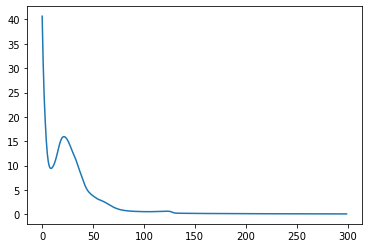

In [920]:
plt.plot(loss_history)

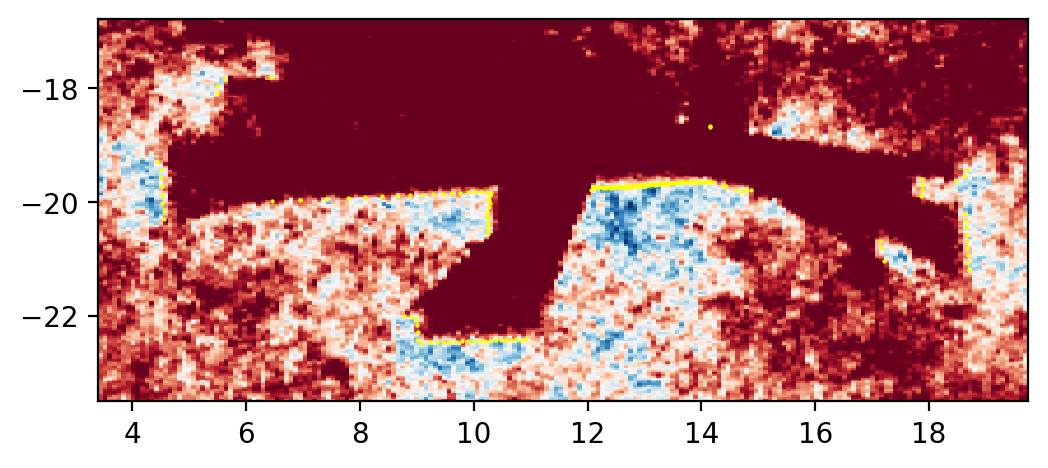

In [921]:
plt.figure(dpi=200)
# plot_model_heatmap(map_model, (-10, 10, -4, 4))
l_threshold = 0
new_hashtable = jnp.concatenate([jnp.zeros((l_threshold, config.T, config.F)), 
                                 map_model.hashtable[l_threshold:]], axis=0)
# new_hashtable = jnp.concatenate([map_model.hashtable[:l_threshold],
#                                  jnp.zeros((config.L - l_threshold, config.T, config.F))], axis=0)
new_map_model = MapModel(hashtable=new_hashtable, variables=map_model.variables, resolutions=map_model.resolutions,
                        origins=map_model.origins, rotations=map_model.rotations)

all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(new_map_model, bounds)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

In [922]:
def get_scan_data(laser_data):
    mask = laser_data.ranges < 10
    return ScanData(angles=jnp.array(laser_data.angles[mask]), depths=jnp.array(laser_data.ranges[mask]))

0.28427902


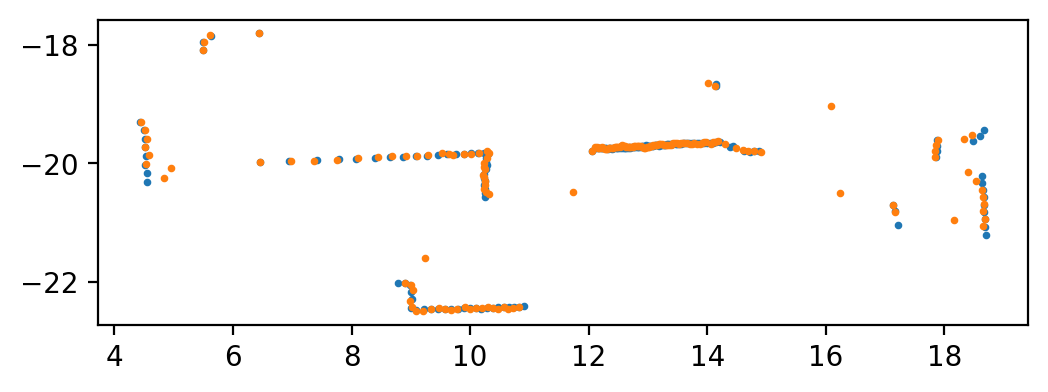

In [923]:
plt.figure(dpi=200)
index = learning_index
laser_data = laser_data_list[index]
scan_data = get_scan_data(laser_data)
learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
position = jnp.array([x, y, angle])

predicted_depths = predict_dephs(new_map_model, position, scan_data, learning_data, config, model)
print(jnp.sqrt(jnp.mean((predicted_depths - scan_data.depths) ** 2)))
new_points = np.stack([np.cos(scan_data.angles) * predicted_depths, 
                       np.sin(scan_data.angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)

In [374]:
# def save_result(metrics, config):
#     path = Path.

In [375]:
# from pathlib import Path

In [376]:
# Path.cwd().joinpath("log/train_single").mkdir(parents=True, exist_ok=True)

In [444]:
jnp.std(map_model.variables["params"]["Dense_0"]["kernel"], axis=1)

DeviceArray([0.30198795, 0.30843908, 0.35976714, 0.2862936 , 0.2850468 ,
             0.24747622, 0.26418984, 0.30281755, 0.2596492 , 0.39624414,
             0.34716493, 0.3617074 , 0.1812008 , 0.25598925, 0.25761816,
             0.32326773, 0.23128538, 0.23797053, 0.16928147, 0.15608567,
             0.22855738, 0.1771434 , 0.1607253 , 0.19102222, 0.18507373,
             0.22062787, 0.19638012, 0.13394089, 0.20795155, 0.17356087,
             0.21952273, 0.18291794, 0.20894024, 0.18079372, 0.22158766,
             0.14515522, 0.15317315, 0.18256918, 0.1375392 , 0.19379856,
             0.19972068, 0.13109288, 0.15473634, 0.11954029, 0.18852042,
             0.14341109, 0.17679815, 0.13833807, 0.18021342, 0.17019828,
             0.17983103, 0.1132268 , 0.14078547, 0.19474876, 0.14451073,
             0.14835808, 0.19378361, 0.16756459, 0.10980098, 0.2262302 ,
             0.17186815, 0.1941384 , 0.13359535, 0.17058796, 0.1544305 ,
             0.20837632, 0.15177895, 0.16617197, 0.